### In this file, we will apply two techniques of proceeding to use a pretrained models
1. Feature extraction without using data augmentation
    A. Running the Conv base over new dataset, store its output to numpy array, 
    B. Feed this Numpy array data as input to standalone, densely connected classifier
2. Feature extraction using data augmentation
    A. Extending the model by adding Dense layer on top of it and run the whole model on the input data

In [4]:
import keras
from keras.applications import VGG16 #VGG16 is a Conv neural network architecture developed by OXford geometry lab

In [13]:
# the arguments are available at keras applications website
wt_imagenet_file = "C:\\Users\Ramy\\.keras\\datasets\\VGG16\\vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [14]:
conv_base = VGG16(weights=wt_imagenet_file, include_top = False,input_shape=(150,150,3))

In [15]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

### feature extraction

In [7]:
import os, shutil

In [17]:
original_dataset_dir = "C:\\Users\Ramy\.keras\datasets\PetImages"
#few images
base_directory = "C:\\Users\Ramy\.keras\datasets\cats_dogs_small"

os.mkdir(base_directory)

In [20]:
train_directory = os.path.join(base_directory, 'train')
validation_directory = os.path.join(base_directory, 'validation')

In [21]:
train_cats_dir = os.path.join(train_directory, 'cats')
train_dogs_dir = os.path.join(train_directory, 'dogs')
validation_cats_dir = os.path.join(validation_directory, 'cats')
validation_dogs_dir = os.path.join(validation_directory, 'dogs')

In [25]:
original_dir_cat = os.path.join(original_dataset_dir, 'Cat')
original_dir_dog = os.path.join(original_dataset_dir, 'Dog')

In [28]:
TrainImages_Count = 200
ValImages_End = 300

In [31]:
fnames = ['{}.jpg'.format(i) for i in range(TrainImages_Count)]
for fnames in fnames:
    src = os.path.join(original_dir_cat, fnames)
    dst = os.path.join(train_cats_dir, fnames)
    shutil.copyfile(src, dst)

fnames = ['{}.jpg'.format(i) for i in range(TrainImages_Count, ValImages_End)]
for fnames in fnames:
    src = os.path.join(original_dir_cat, fnames)
    dst = os.path.join(validation_cats_dir, fnames)
    shutil.copyfile(src, dst)

    
fnames = ['{}.jpg'.format(i) for i in range(TrainImages_Count)]
for fnames in fnames:
    src = os.path.join(original_dir_dog, fnames)
    dst = os.path.join(train_dogs_dir, fnames)
    shutil.copyfile(src, dst)

fnames = ['{}.jpg'.format(i) for i in range(TrainImages_Count, ValImages_End)]
for fnames in fnames:
    src = os.path.join(original_dir_dog, fnames)
    dst = os.path.join(validation_dogs_dir, fnames)
    shutil.copyfile(src, dst)

In [32]:
len(os.listdir(train_cats_dir))

200

In [33]:
len(os.listdir(validation_cats_dir))

100

### Feature extraction using numpy( not DA)
note that: the final feature map has (4,4,512) from the info of the summary of VGG16

In [34]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [35]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

In [36]:
def extract_feature(directory, sample_count):
    features = np.zeros(shape =(sample_count, 4, 4, 512))
    labels = np.zeros(shape= (sample_count))
    generator = datagen.flow_from_directory(directory, target_size=(150,150), batch_size=batch_size, class_mode='binary')
    i = 0
    for input_batch, labels_batch in generator:
        # features extracting by calling the predicting method of the model conv_base
        features_batch = conv_base.predict(input_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i = i + 1
        print("i: ", i)
        if i * batch_size >= sample_count:
            print("loob broken ")
            break
    return features, labels

In [37]:
train_img_count = 200
trian_features, train_labels = extract_feature(train_directory, train_img_count) # 2000

Found 400 images belonging to 2 classes.
i:  1
i:  2
i:  3
i:  4
i:  5
i:  6
i:  7
i:  8
i:  9
i:  10
loob broken 


In [38]:
val_img_count = 100
validation_features, validation_labels = extract_feature(validation_directory, val_img_count) #1000

Found 200 images belonging to 2 classes.
i:  1
i:  2
i:  3
i:  4
i:  5
loob broken 


### Flatten
The extracted features are now of shape(4,4,512)
Before feeding them to a desne classifier, first we flatten them to (samples, 8192)

In [40]:
trian_features = np.reshape(trian_features, (train_img_count, 4*4*512))

In [41]:
validation_features = np.reshape(validation_features, (val_img_count, 4*4*512))

### defining and training densely connected classifiers

In [42]:
from keras import models, layers, optimizers

In [43]:
model = models.Sequential()
model.add(layers.Dense(256, activation= 'relu', input_dim = 4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [53]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________


In [44]:
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [45]:
Model_fitting = model.fit(trian_features, train_labels, epochs=10, batch_size = 20,
                          validation_data=(validation_features, validation_labels)) #the iteration will be fast because of np

Epoch 1/10
10/10 [==============================] - 1s 42ms/step - loss: 0.7189 - accuracy: 0.5661 - val_loss: 0.6687 - val_accuracy: 0.5700
Epoch 2/10
10/10 [==============================] - 0s 28ms/step - loss: 0.7050 - accuracy: 0.5726 - val_loss: 0.6320 - val_accuracy: 0.6100
Epoch 3/10
10/10 [==============================] - 0s 25ms/step - loss: 0.6220 - accuracy: 0.6488 - val_loss: 0.5952 - val_accuracy: 0.6900
Epoch 4/10
10/10 [==============================] - 0s 29ms/step - loss: 0.5652 - accuracy: 0.7027 - val_loss: 0.5690 - val_accuracy: 0.7300
Epoch 5/10
10/10 [==============================] - 0s 26ms/step - loss: 0.6227 - accuracy: 0.6133 - val_loss: 0.5508 - val_accuracy: 0.7400
Epoch 6/10
10/10 [==============================] - 0s 26ms/step - loss: 0.4885 - accuracy: 0.7676 - val_loss: 0.5259 - val_accuracy: 0.7900
Epoch 7/10
10/10 [==============================] - 0s 28ms/step - loss: 0.4429 - accuracy: 0.8112 - val_loss: 0.5021 - val_accuracy: 0.8200
Epoch 8/10
10

In [46]:
acc = Model_fitting.history['accuracy']
val_acc = Model_fitting.history['val_accuracy']
loss = Model_fitting.history['loss']
val_loss = Model_fitting.history['val_loss']
epochs = range(1, len(acc) + 1)

In [47]:
import matplotlib.pyplot as plt

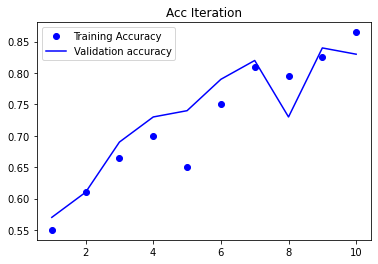

In [49]:
plt.plot(epochs, acc, 'bo', label= 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation accuracy')
plt.title('Acc Iteration')
plt.legend()

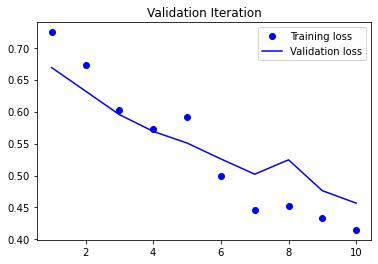

In [50]:
plt.plot(epochs, loss, 'bo', label= 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Validation Iteration')
plt.legend()

### Feature extraction using Data augmentation

In [51]:
New_model = models.Sequential()
New_model.add(conv_base)
New_model.add(layers.Flatten())
New_model.add(layers.Dense(256, activation= 'relu', input_dim = 4*4*512))
New_model.add(layers.Dense(1, activation = 'sigmoid'))

In [52]:
New_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [55]:
print('Num of trainable weights before freezing the conv_base: ',len(New_model.trainable_weights) )

Num of trainable weights before freezing the conv_base:  30


In [56]:
conv_base.trainable = False

In [58]:
print('Num of trainable weights after freezing the conv_base: ',len(New_model.trainable_weights) )

Num of trainable weights after freezing the conv_base:  4


In [59]:
train_data_generator = ImageDataGenerator(rescale=1./255,
                                         rotation_range=40,
                                         width_shift_range=0.2,
                                         height_shift_range=0.2,
                                         shear_range=0.2,
                                         zoom_range=0.2,
                                         horizontal_flip=True,
                                         fill_mode='nearest')

In [60]:
test_data_generator = ImageDataGenerator(rescale=1./255)

In [61]:
train_generator = train_data_generator.flow_from_directory(train_directory,
                                                          target_size=(150,150),
                                                          batch_size=20,
                                                          class_mode='binary')
validation_generator = test_data_generator.flow_from_directory(validation_directory,
                                                              target_size=(150,150),
                                                              batch_size=20,
                                                              class_mode='binary')

Found 400 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [62]:
New_model.compile(loss = 'binary_crossentropy',
                 optimizer = optimizers.RMSprop(lr=2e-5),
                 metrics=['accuracy'])

In [64]:
New_model_fitting = New_model.fit(train_generator, steps_per_epoch=200,
                                 epochs=2,
                                 validation_data=validation_generator,
                                 validation_steps=50) # the model will train verrry slow! numpy is much better

Epoch 1/2
 19/200 [=>............................] - ETA: 6:45 - loss: 0.5935 - accuracy: 0.7289

KeyboardInterrupt: 